# Toy 1d Example for Review Paper

In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from scipy.stats import qmc
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns

from uncprop.utils.grid import Grid, DensityComparisonGrid
from uncprop.core.inverse_problem import Prior, Posterior
from uncprop.core.distribution import DistributionFromDensity
from uncprop.utils.gpjax_models import construct_gp
from uncprop.utils.distribution import _gaussian_log_density_tril
from uncprop.utils.other import _numpy_rng_seed_from_jax_key
from uncprop.utils.gpjax_multioutput import BatchedRBF
from uncprop.models.vsem.surrogate import _estimate_ep_grid

from uncprop.core.surrogate import (
    construct_design, 
    GPJaxSurrogate, 
    FwdModelGaussianSurrogate,
    LogDensGPSurrogate,
    LogDensClippedGPSurrogate,
)
from uncprop.utils.plot import (
    set_plot_theme, 
    smart_subplots,
    plot_gp_1d,
)

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
out_dir = base_dir / 'out' / 'review_final'

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [2]:
key = jr.key(325234)

# plot settings
n_grid = 100

# exact inverse problem
noise_sd = 0.1
time_horizon = (-3, 3)
support = (0, 1)
true_param = 0.5
n_time = 8

# surrogate settings
x_design = jnp.array([0.4, 0.8, 0.9]).reshape(-1, 1)
jitter = 0.0

In [ ]:
# Plotting
gp_colors = {
    "mean":     "#4477AA",
    "interval": "#77AADD",
    "points":   "#888888",
    "true":     "#000000"
}

colors = set_plot_theme()

# sns.set_theme(style='ticks', palette='colorblind')
sns.set_context(
    "paper",
    font_scale=2.0,
    rc={"lines.linewidth": 3,
        "axes.linewidth": 1.5}
)

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


## Helper Functions

In [4]:
def wrap_gp(gp, design, jitter):
    """Wrap single output gpjax GP as batch GPJaxSurrogate object"""
    ker = gp.prior.kernel
    batched_kernel = BatchedRBF(batch_dim=1, input_dim=ker.n_dims,
                                lengthscale=ker.lengthscale,
                                variance=ker.variance)
    batched_gp_prior = gpx.gps.Prior(mean_function=gp.prior.mean_function,
                                     kernel=batched_kernel)
    batched_gp_post = batched_gp_prior * gp.likelihood
    return GPJaxSurrogate(gp=batched_gp_post, design=design, jitter=jitter)

In [5]:
class FwdModelGaussianSurrogateGrid(FwdModelGaussianSurrogate):
    """Posterior surrogate induced by forward model surrogate
    
    Defines method to approximate EP over a grid.
    """
    def expected_normalized_density_approx(self,
                                           key,
                                           *,
                                           grid,
                                           n_mc: int = 10_000,
                                           **method_kwargs):

        cell_area = grid.cell_area
        input_dim = self.surrogate.input_dim
        y = self.y
        noise_cov_tril = self.noise_cov_tril

        def log_dens(x):
            fwd_samp = self.surrogate(x).sample(key, n=n_mc) # (n_mc, n_x)
            log_prior_dens = self.log_prior(x)

            log_lik_vals = jnp.zeros(fwd_samp.shape)
            for i in range(fwd_samp.shape[1]):
                l = _gaussian_log_density_tril(y, m=fwd_samp[:,i].reshape(-1,1), L=noise_cov_tril)
                log_lik_vals = log_lik_vals.at[:,i].set(l)

            log_post_samp = log_prior_dens + log_lik_vals
            return _estimate_ep_grid(log_post_samp, cell_area=cell_area)

        return DistributionFromDensity(log_dens=log_dens, dim=input_dim)


class LogDensGPSurrogateGrid(LogDensGPSurrogate):
    """Posterior surrogate induced by log-density surrogate
    
    Defines method to approximate EP over a grid.
    """
    def expected_normalized_density_approx(self,
                                           key,
                                           *,
                                           grid,
                                           n_mc: int = 10_000,
                                           **method_kwargs):
        
            cell_area = grid.cell_area
            input_dim = self.surrogate.input_dim

            def log_dens(x):
                log_post_samp = self.surrogate(x).sample(key, n=n_mc) # (n_mc, n_x)
                return _estimate_ep_grid(log_post_samp, cell_area=cell_area)

            return DistributionFromDensity(log_dens=log_dens, dim=input_dim)

In [ ]:
def get_density_grid(key, grid, post_em, post_true):
    dists = {
        'exact': post_true,
        'mean': post_em.expected_surrogate_approx(),
        'eup': post_em.expected_density_approx(),
        'ep': post_em.expected_normalized_density_approx(key, grid=grid)
    }

    return DensityComparisonGrid(grid=grid, distributions=dists)

def save_ldens_em_plots(key, grid, f, post_em, post_true, out_dir, gp_colors, post_colors):
    key, key_grid = jr.split(key)
    dens_grid = get_density_grid(key_grid, grid, post_em, post_true)
    surr = post_em.surrogate

    # emulator plot
    pred = surr(grid.flat_grid)
    fig_em, ax_em = plot_gp_1d(x=grid.flat_grid.ravel(),
                               mean=pred.mean,
                               sd=pred.stdev,
                               points=surr.design,
                               true_y=f(grid.flat_grid),
                               colors=gp_colors)
    ax_em.set_xlabel('u')
    ax_em.set_ylabel('log L(u)')
    



## Exact Inverse Problem

In [6]:
# Forward Model
times = jnp.linspace(time_horizon[0], time_horizon[1], n_time)
noise_var = noise_sd ** 2

def forward(u):
    u = jnp.atleast_2d(u)
    xt = jnp.exp(u * times)
    return jnp.mean(xt, axis=1)

In [7]:
# Ground truth
key, key_noise = jr.split(key)

true_observable = forward(true_param)
true_noise = noise_sd * jr.normal(key_noise)
y = true_observable + true_noise

In [8]:
# exact inverse problem 

def log_lik(u):
    return -0.5 * jnp.log(2*jnp.pi*noise_var) - 0.5 * (y - forward(u))**2 / noise_var

class Prior1d(Prior):

    @property
    def dim(self):
        return 1

    @property
    def support(self):
        return support
     
    @property
    def par_names(self):
        return ['u']
    
    def log_density(self, u):
        u = jnp.atleast_2d(u)
        n_inputs = u.shape[0]
        a,b = self.support
        log_dens = -jnp.log(b - a)
        return jnp.tile(log_dens, n_inputs)
    
    def sample(self, key, n: int = 1):
        return jr.uniform(key, shape=(n, self.dim), 
                          minval=self.support[0],
                          maxval=self.support[1])
    
    def sample_lhc(self, key, n: int = 1):
        """Latin hypercube sample"""
        rng_key = _numpy_rng_seed_from_jax_key(key)
        rng = default_rng(seed=rng_key)
        lhc = qmc.LatinHypercube(d=self.dim, rng=rng)

        samp = lhc.random(n=n)
        a,b = self.support
        return jnp.asarray(a + samp * (b - a))
    
prior = Prior1d()
posterior = Posterior(prior, log_lik)

In [9]:
grid = Grid(low=support[0], high=support[1], 
            n_points_per_dim=n_grid, 
            dim_names=prior.par_names)

## Forward Model Surrogate

In [10]:
# construct design
forward_design = gpx.Dataset(X=x_design,
                             y=forward(x_design).reshape(-1, 1))

# fit GP surrogate
forward_gp, _ = construct_gp(forward_design, set_bounds=False, prior_mean='constant')
forward_surrogate = wrap_gp(forward_gp, forward_design, jitter)

# Induced posterior surrogate
fwd_post_surr = FwdModelGaussianSurrogateGrid(gp=forward_surrogate,
                                              log_prior=posterior.prior.log_density,
                                              y=y.reshape(1,1),
                                              noise_cov_tril=jnp.array(noise_sd).reshape(1, 1),
                                              support=posterior.support)

In [11]:
key, key_ep = jr.split(key)

forward_dists = {
    'exact': posterior,
    'mean': fwd_post_surr.expected_surrogate_approx(),
    'eup': fwd_post_surr.expected_density_approx(),
    'ep': fwd_post_surr.expected_normalized_density_approx(key_ep, grid=grid)
}

forward_dens_grid = DensityComparisonGrid(grid=grid,
                                          distributions=forward_dists)

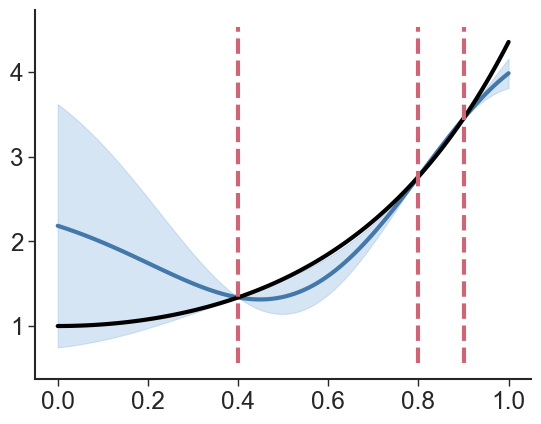

In [12]:
pred = forward_surrogate(grid.flat_grid)

fig, ax = plot_gp_1d(x=grid.flat_grid.ravel(),
                     mean=pred.mean,
                     sd=pred.stdev,
                     points=forward_design.X,
                     true_y=forward(grid.flat_grid),
                     colors=gp_colors)

In [23]:
ylim = ax.get_ylim()

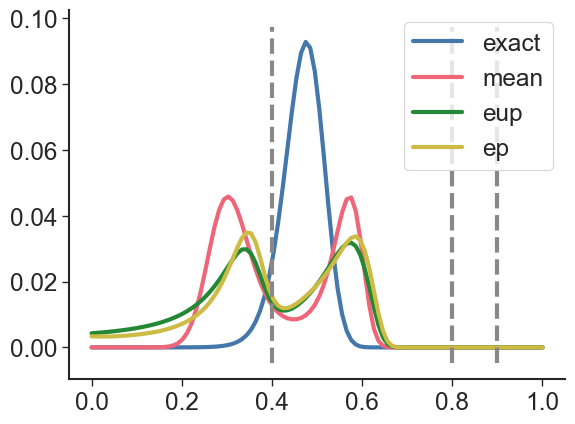

In [ ]:
fig, ax = forward_dens_grid.plot(normalized=True, 
                                 log_scale=False, 
                                 points=forward_design.X,
                                 colors=colors)

## Log-Density Surrogate

In [14]:
# same design inputs as forward model surrogate
ldens_design = gpx.Dataset(X=forward_design.X,
                           y=posterior.log_density(forward_design.X).reshape(-1, 1))

# fit GP surrogate
ldens_gp, _ = construct_gp(ldens_design, set_bounds=False, prior_mean='constant')
ldens_surrogate = wrap_gp(ldens_gp, ldens_design, jitter)

# Induced posterior surrogate    
ldens_post_surr = LogDensGPSurrogateGrid(log_dens=ldens_surrogate, support=posterior.support)

In [15]:
key, key_ep = jr.split(key)

ldens_dists = {
    'exact': posterior,
    'mean': ldens_post_surr.expected_surrogate_approx(),
    'eup': ldens_post_surr.expected_density_approx(),
    'ep': ldens_post_surr.expected_normalized_density_approx(key_ep, grid=grid)
}

ldens_dens_grid = DensityComparisonGrid(grid=grid,
                                        distributions=ldens_dists)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

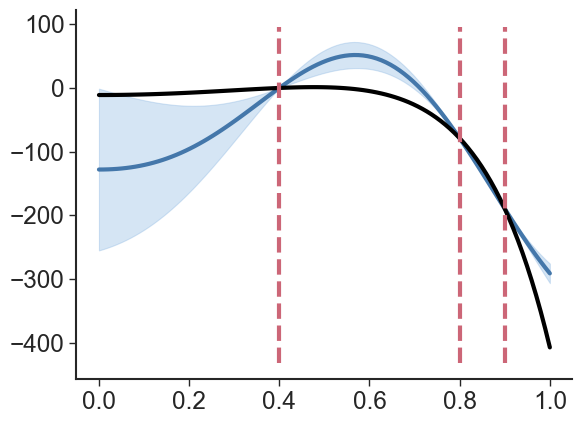

In [17]:
pred = ldens_surrogate(grid.flat_grid)

plot_gp_1d(x=grid.flat_grid.ravel(),
           mean=pred.mean,
           sd=pred.stdev,
           points=ldens_design.X,
           true_y=posterior.log_density(grid.flat_grid),
           colors=gp_colors)

(0.0, 0.3)

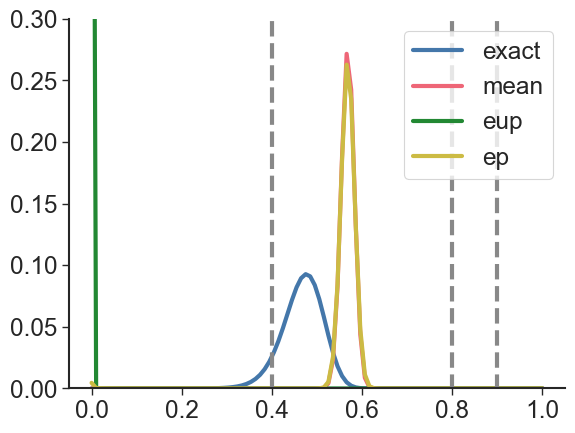

In [28]:
fig, ax = ldens_dens_grid.plot(normalized=True, 
                               log_scale=False, 
                               points=ldens_design.X,
                               colors=colors)
ax.set_ylim((0, 0.3))